# SIGN LANGUAGE CLASSIFICATION
# DTSA-5510-FINAL
# KEITH S.

**ABSTRACT**

**This project will attempt to classify a dataset of sign language pictures using an unsupervised clustering model. This problem has already been solved using supervised and deep learning models but i could not find any succesfull attempts using unsupervised clustering.**

**DATASET**\
https://www.kaggle.com/datasets/datamunge/sign-language-mnist \
Data set is from kaggle.com and was uploaded by user TECPERSON . The dataset contains pictures in the MNIST style containing 28x28 pixel image data with greyscale values between 0-255.

This report will be broken up into the following sections. 

1. EDA

    1.1 Import Data    
    1.2 Explore Data    
    1.3 NULL characters    
    1.4 Clean     
    1.5 Visualizations

2. Dimensionality Reduction

    2.1 PCA    
    2.2 LSA     

3. K-Means Model

    3.1 Build Model   
    3.2 Tune Model    
    3.3 Analysis            
    
4. Alternative Cluster Models
 
    4.1 Heirachal based model    
    4.2 Distribution based model      
    4.3 Analysis

5. Ensemble Cluster Model

    5.1 Cluster function   
    5.2 Build Model    
    5.3 Tune Model    
    5.4 Analysis

6. Supervised Model
    
    6.1 Build Model    
    6.2 Hyper parameter tuning    
    6.3 analysis
    
7. Conclusion

    7.1 Comparison of unsupervised models    
    7.2 Comparison to supervised model   
    7.3 Final Analysis

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from PIL import Image
import imageio.v2 as imageio
import itertools
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans, KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.cluster import OPTICS, MeanShift, AffinityPropagation, Birch, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist
from scipy.sparse.csgraph import connected_components
import random
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from sklearn.datasets import fetch_openml
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/sign-language-mnist/sign_mnist_test.csv
/kaggle/input/sign-language-mnist/amer_sign2.png
/kaggle/input/sign-language-mnist/amer_sign3.png
/kaggle/input/sign-language-mnist/sign_mnist_train.csv
/kaggle/input/sign-language-mnist/american_sign_language.PNG
/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv
/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv


In [3]:
# Helper function from previous version of sklearn. 

def linear_assignment(X):
    """Solve the linear assignment problem using the Hungarian algorithm.

    The problem is also known as maximum weight matching in bipartite graphs.
    The method is also known as the Munkres or Kuhn-Munkres algorithm.

    Parameters
    ----------
    X : array
        The cost matrix of the bipartite graph

    Returns
    -------
    indices : array
        The pairs of (row, col) indices in the original array giving
        the original ordering.

    References
    ----------

    1. http://www.public.iastate.edu/~ddoty/HungarianAlgorithm.html

    2. Harold W. Kuhn. The Hungarian Method for the assignment problem.
       *Naval Research Logistics Quarterly*, 2:83-97, 1955.

    3. Harold W. Kuhn. Variants of the Hungarian method for assignment
       problems. *Naval Research Logistics Quarterly*, 3: 253-258, 1956.

    4. Munkres, J. Algorithms for the Assignment and Transportation Problems.
       *Journal of the Society of Industrial and Applied Mathematics*,
       5(1):32-38, March, 1957.

    5. https://en.wikipedia.org/wiki/Hungarian_algorithm
    """
    indices = _hungarian(X).tolist()
    indices.sort()
    # Re-force dtype to ints in case of empty list
    indices = np.array(indices, dtype=int)
    # Make sure the array is 2D with 2 columns.
    # This is needed when dealing with an empty list
    indices.shape = (-1, 2)
    return indices



class _HungarianState(object):
    """State of one execution of the Hungarian algorithm.

    Parameters
    ----------
    cost_matrix : 2D matrix
        The cost matrix. Does not have to be square.
    """

    def __init__(self, cost_matrix):
        cost_matrix = np.atleast_2d(cost_matrix)

        # If there are more rows (n) than columns (m), then the algorithm
        # will not be able to work correctly. Therefore, we
        # transpose the cost function when needed. Just have to
        # remember to swap the result columns back later.
        transposed = (cost_matrix.shape[1] < cost_matrix.shape[0])
        if transposed:
            self.C = (cost_matrix.T).copy()
        else:
            self.C = cost_matrix.copy()
        self.transposed = transposed

        # At this point, m >= n.
        n, m = self.C.shape
        self.row_uncovered = np.ones(n, dtype=bool)
        self.col_uncovered = np.ones(m, dtype=bool)
        self.Z0_r = 0
        self.Z0_c = 0
        self.path = np.zeros((n + m, 2), dtype=int)
        self.marked = np.zeros((n, m), dtype=int)

    def _clear_covers(self):
        """Clear all covered matrix cells"""
        self.row_uncovered[:] = True
        self.col_uncovered[:] = True


def _hungarian(cost_matrix):
    """The Hungarian algorithm.

    Calculate the Munkres solution to the classical assignment problem and
    return the indices for the lowest-cost pairings.

    Parameters
    ----------
    cost_matrix : 2D matrix
        The cost matrix. Does not have to be square.

    Returns
    -------
    indices : 2D array of indices
        The pairs of (row, col) indices in the original array giving
        the original ordering.
    """
    state = _HungarianState(cost_matrix)

    # No need to bother with assignments if one of the dimensions
    # of the cost matrix is zero-length.
    step = None if 0 in cost_matrix.shape else _step1

    while step is not None:
        step = step(state)

    # Look for the starred columns
    results = np.array(np.where(state.marked == 1)).T

    # We need to swap the columns because we originally
    # did a transpose on the input cost matrix.
    if state.transposed:
        results = results[:, ::-1]

    return results


# Individual steps of the algorithm follow, as a state machine: they return
# the next step to be taken (function to be called), if any.

def _step1(state):
    """Steps 1 and 2 in the Wikipedia page."""

    # Step1: For each row of the matrix, find the smallest element and
    # subtract it from every element in its row.
    state.C -= state.C.min(axis=1)[:, np.newaxis]
    # Step2: Find a zero (Z) in the resulting matrix. If there is no
    # starred zero in its row or column, star Z. Repeat for each element
    # in the matrix.
    for i, j in zip(*np.where(state.C == 0)):
        if state.col_uncovered[j] and state.row_uncovered[i]:
            state.marked[i, j] = 1
            state.col_uncovered[j] = False
            state.row_uncovered[i] = False

    state._clear_covers()
    return _step3


def _step3(state):
    """
    Cover each column containing a starred zero. If n columns are covered,
    the starred zeros describe a complete set of unique assignments.
    In this case, Go to DONE, otherwise, Go to Step 4.
    """
    marked = (state.marked == 1)
    state.col_uncovered[np.any(marked, axis=0)] = False

    if marked.sum() < state.C.shape[0]:
        return _step4


def _step4(state):
    """
    Find a noncovered zero and prime it. If there is no starred zero
    in the row containing this primed zero, Go to Step 5. Otherwise,
    cover this row and uncover the column containing the starred
    zero. Continue in this manner until there are no uncovered zeros
    left. Save the smallest uncovered value and Go to Step 6.
    """
    # We convert to int as numpy operations are faster on int
    C = (state.C == 0).astype(int)
    covered_C = C * state.row_uncovered[:, np.newaxis]
    covered_C *= state.col_uncovered.astype(dtype=int, copy=False)
    n = state.C.shape[0]
    m = state.C.shape[1]
    while True:
        # Find an uncovered zero
        row, col = np.unravel_index(np.argmax(covered_C), (n, m))
        if covered_C[row, col] == 0:
            return _step6
        else:
            state.marked[row, col] = 2
            # Find the first starred element in the row
            star_col = np.argmax(state.marked[row] == 1)
            if not state.marked[row, star_col] == 1:
                # Could not find one
                state.Z0_r = row
                state.Z0_c = col
                return _step5
            else:
                col = star_col
                state.row_uncovered[row] = False
                state.col_uncovered[col] = True
                covered_C[:, col] = C[:, col] * (
                    state.row_uncovered.astype(dtype=int, copy=False))
                covered_C[row] = 0


def _step5(state):
    """
    Construct a series of alternating primed and starred zeros as follows.
    Let Z0 represent the uncovered primed zero found in Step 4.
    Let Z1 denote the starred zero in the column of Z0 (if any).
    Let Z2 denote the primed zero in the row of Z1 (there will always be one).
    Continue until the series terminates at a primed zero that has no starred
    zero in its column. Unstar each starred zero of the series, star each
    primed zero of the series, erase all primes and uncover every line in the
    matrix. Return to Step 3
    """
    count = 0
    path = state.path
    path[count, 0] = state.Z0_r
    path[count, 1] = state.Z0_c

    while True:
        # Find the first starred element in the col defined by
        # the path.
        row = np.argmax(state.marked[:, path[count, 1]] == 1)
        if not state.marked[row, path[count, 1]] == 1:
            # Could not find one
            break
        else:
            count += 1
            path[count, 0] = row
            path[count, 1] = path[count - 1, 1]

        # Find the first prime element in the row defined by the
        # first path step
        col = np.argmax(state.marked[path[count, 0]] == 2)
        if state.marked[row, col] != 2:
            col = -1
        count += 1
        path[count, 0] = path[count - 1, 0]
        path[count, 1] = col

    # Convert paths
    for i in range(count + 1):
        if state.marked[path[i, 0], path[i, 1]] == 1:
            state.marked[path[i, 0], path[i, 1]] = 0
        else:
            state.marked[path[i, 0], path[i, 1]] = 1

    state._clear_covers()
    # Erase all prime markings
    state.marked[state.marked == 2] = 0
    return _step3


def _step6(state):
    """
    Add the value found in Step 4 to every element of each covered row,
    and subtract it from every element of each uncovered column.
    Return to Step 4 without altering any stars, primes, or covered lines.
    """
    # the smallest uncovered value in the matrix
    if np.any(state.row_uncovered) and np.any(state.col_uncovered):
        minval = np.min(state.C[state.row_uncovered], axis=0)
        minval = np.min(minval[state.col_uncovered])
        state.C[np.logical_not(state.row_uncovered)] += minval
        state.C[:, state.col_uncovered] -= minval
    return _step4

In [4]:
# Helper function to relabel clusters and maximize accuracy

# convert confusion matrix into cost matrix
def make_cost(cm):
    s = np.max(cm)
    return (- cm + s)

# relabel y_prediction with correct labels
def cm_disp(labelorder, yp, yt):
    i = 0
    yp_temp = []
    # update prediction matrix
    for x in range(len(yp)):
        z = labelorder[yp[x]]
        yp_temp.append(z)
            
    y_pred = yp_temp

    acc = accuracy_score(yt,y_pred)
    #print(acc)

    #cm = confusion_matrix(yt,y_pred)
    cmd = ConfusionMatrixDisplay.from_predictions(yt,y_pred)

    return cmd , acc , y_pred

# get correct labels that maximize accuracy metric
def get_labels(y_true,y_pred):
    cm = confusion_matrix(y_true,y_pred)
    
    index = linear_assignment(make_cost(cm))
    perm = [x[1] for x in sorted(index, key = lambda i: i[0])]
    
    cm2 = cm[:,perm]
    acc = np.trace(cm2) / np.sum(cm2)
    temp = {}
    for label in index:
        temp[label[1]] = label[0]
    labels = temp
    cmd , acc2 , yp = cm_disp(labels,y_pred,y_true)
    
    return cmd ,acc2 , yp
    
    

In [5]:
# 1.1
# import dataset into data frame 

df_train = pd.read_csv('/kaggle/input/sign-language-mnist/sign_mnist_train.csv')
df_test = pd.read_csv('/kaggle/input/sign-language-mnist/sign_mnist_test.csv')

img2 = '/kaggle/input/sign-language-mnist/amer_sign2.png'
img3 = '/kaggle/input/sign-language-mnist/amer_sign3.png'



In [6]:
# 1.2
# Explore Dataset look for any obvious anomalies

print(df_train.head())
print(df_train.info())

   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      3     107     118     127     134     139     143     146     150   
1      6     155     157     156     156     156     157     156     158   
2      2     187     188     188     187     187     186     187     188   
3      2     211     211     212     212     211     210     211     210   
4     13     164     167     170     172     176     179     180     184   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0     153  ...       207       207       207       207       206       206   
1     158  ...        69       149       128        87        94       163   
2     187  ...       202       201       200       199       198       199   
3     210  ...       235       234       233       231       230       226   
4     185  ...        92       105       105       108       133       163   

   pixel781  pixel782  pixel783  pixel784  
0       206       204       20

In [7]:
# 1.3 null characters
df_train.isna().sum().sum()

0

The dataset has 0 null characters

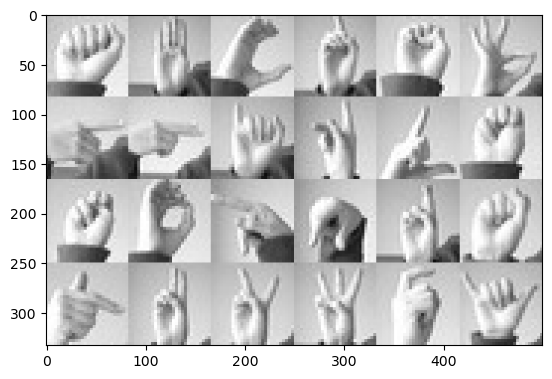

In [8]:
# 1.4
# visualizations
# load example 28x28 pixel image
im = imageio.imread(img3)
plt.imshow(im)

24


(array([1126., 1010., 1144., 1196.,  957., 1204., 1090., 1013., 1162.,
           0., 1114., 1241., 1055., 1151., 1196., 1088., 1279., 1294.,
        1199., 1186., 1161., 1082., 1225., 1164., 1118.]),
 array([ 0.  ,  0.96,  1.92,  2.88,  3.84,  4.8 ,  5.76,  6.72,  7.68,
         8.64,  9.6 , 10.56, 11.52, 12.48, 13.44, 14.4 , 15.36, 16.32,
        17.28, 18.24, 19.2 , 20.16, 21.12, 22.08, 23.04, 24.  ]),
 <BarContainer object of 25 artists>)

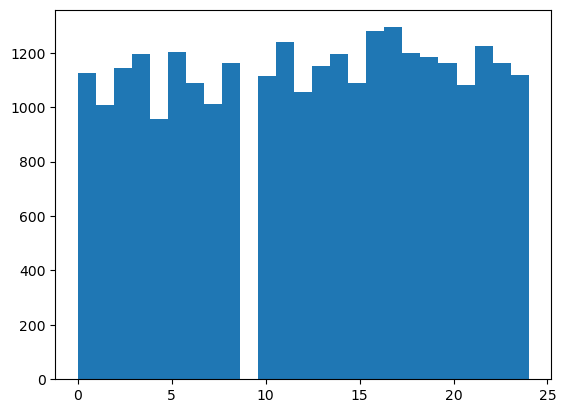

In [9]:
# count frequency of each label
kn = len(pd.unique(df_train['label']))
print(kn)
pyplot.hist(df_train['label'], bins = kn+1)

In [10]:
# lets split our train data

# pull our Y labels out of the train df
y_train = df_train.pop('label')
y_test = df_test.pop('label')
# rename the train df to X_train
X_train = df_train
X_test = df_test


# 2 

# Dimensionality Reduction

In [11]:
# 2 Dimensionality Reduction
# 2.1 PCA

# Lets perform PCA and transform our data
# goal for our pca is 90% explained variance
pca = PCA(n_components = 58)
X_pca = pca.fit_transform(X_train)
explained_variance = pca.explained_variance_ratio_.sum()

#print(f"LSA done in {time() - t0:.3f} s")
print(f"Explained variance of the PCA step: {explained_variance * 100:.1f}%")

Explained variance of the PCA step: 90.0%


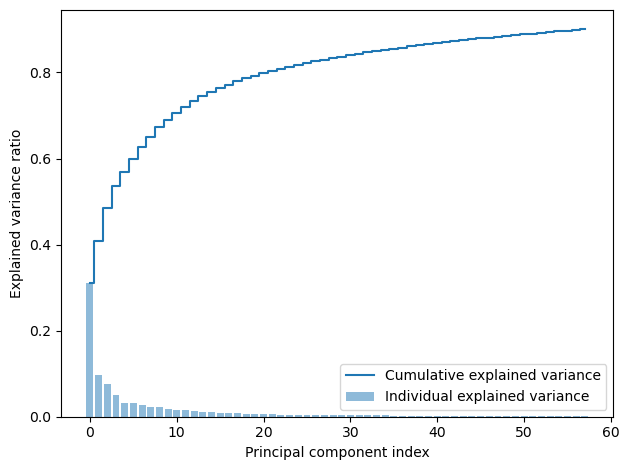

In [12]:
# display explained variance for 58 components
evr = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(evr)
plt.bar(range(0,len(evr)), evr, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Explained variance of the SVD step: 90.6%


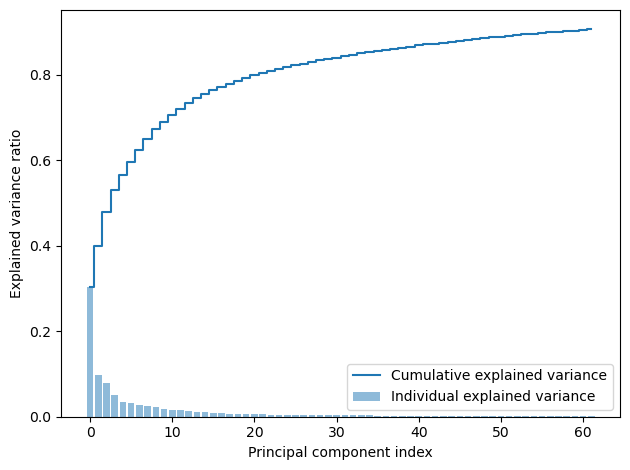

In [13]:

lsa = make_pipeline(TruncatedSVD(n_components=62), Normalizer(copy=False))

X_lsa = lsa.fit_transform(X_train)
X_lsa_test = lsa.transform(X_test)
explained_variance = lsa[0].explained_variance_ratio_.sum()

print(f"Explained variance of the SVD step: {explained_variance * 100:.1f}%")
evr = lsa[0].explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(evr)
plt.bar(range(0,len(evr)), evr, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# 3. 

# K-Means Model

In [14]:
#3 K-Means model
#3.1 lets initialize and train our simple K-Means model
mod_km_pca = KMeans(n_clusters=kn).fit(X_pca)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(array([1341., 1048., 1444., 1927.,  925.,  940., 1875., 2029., 1100.,
         594., 1601.,  444., 1374.,  250., 1452.,  807., 1625.,  822.,
        1583.,  717., 1600.,  393.,  841.,  723.]),
 array([ 0.        ,  0.95833333,  1.91666667,  2.875     ,  3.83333333,
         4.79166667,  5.75      ,  6.70833333,  7.66666667,  8.625     ,
         9.58333333, 10.54166667, 11.5       , 12.45833333, 13.41666667,
        14.375     , 15.33333333, 16.29166667, 17.25      , 18.20833333,
        19.16666667, 20.125     , 21.08333333, 22.04166667, 23.        ]),
 <BarContainer object of 24 artists>)

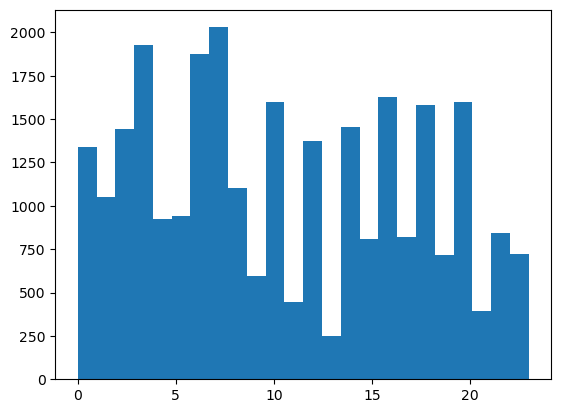

In [15]:
# lets look at the distribution of our predictions
pyplot.hist(mod_km_pca.labels_, bins = kn)

0.18419231469677655


Text(0.5, 0.98, 'Plot of confusion matrix-Kmeans-PCA')

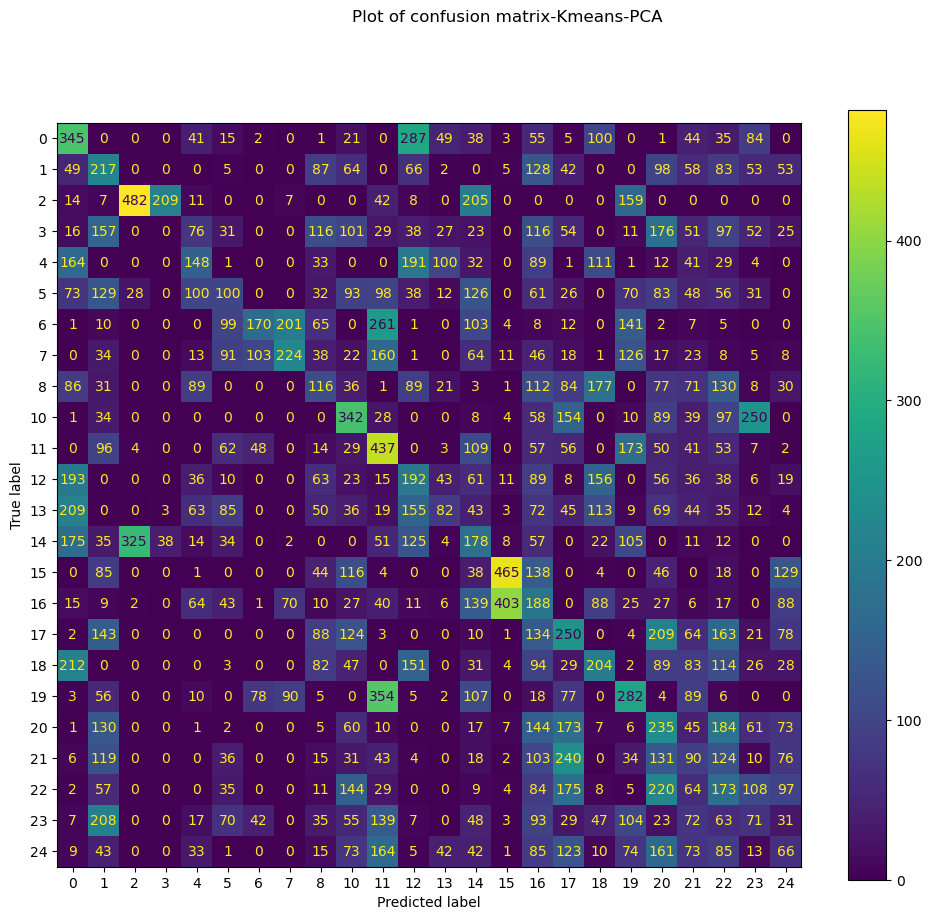

In [16]:
# initial basic K-means accuracy - confusion matrix 

cm , acc, y_pred_km = get_labels(y_train, mod_km_pca.labels_)
print(acc)

fig = cm.figure_
fig.set_figwidth(12)
fig.set_figheight(10) 
fig.suptitle('Plot of confusion matrix-Kmeans-PCA')

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0.2583864505554544


Text(0.5, 0.98, 'Plot of confusion matrix-Kmeans-LSA')

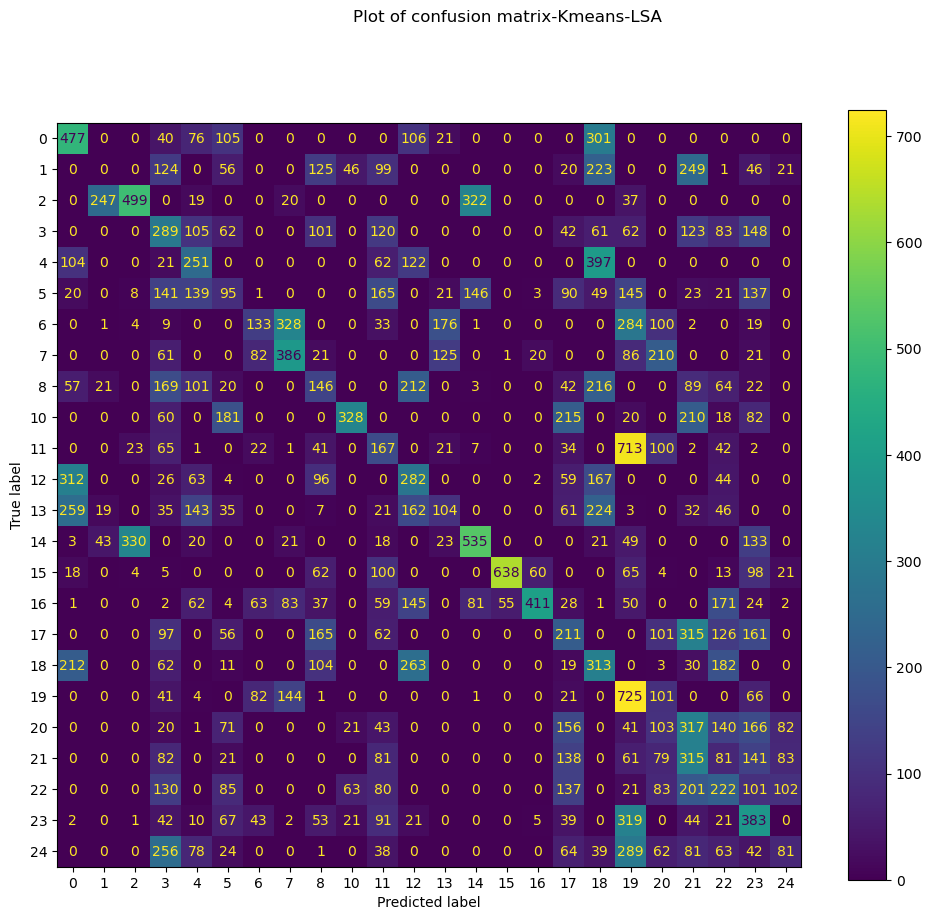

In [17]:
# lets try another K-means algorithm with lsa
mod_km_lsa = KMeans(n_clusters=kn ).fit(X_lsa)
cm , acc_km_train, y_pred_lsa = get_labels(y_train, mod_km_lsa.labels_)
print(acc_km_train)
fig = cm.figure_
fig.set_figwidth(12)
fig.set_figheight(10) 
fig.suptitle('Plot of confusion matrix-Kmeans-LSA')

0.30688789737869493


Text(0.5, 0.98, 'Plot of confusion matrix-Kmeans-LSA')

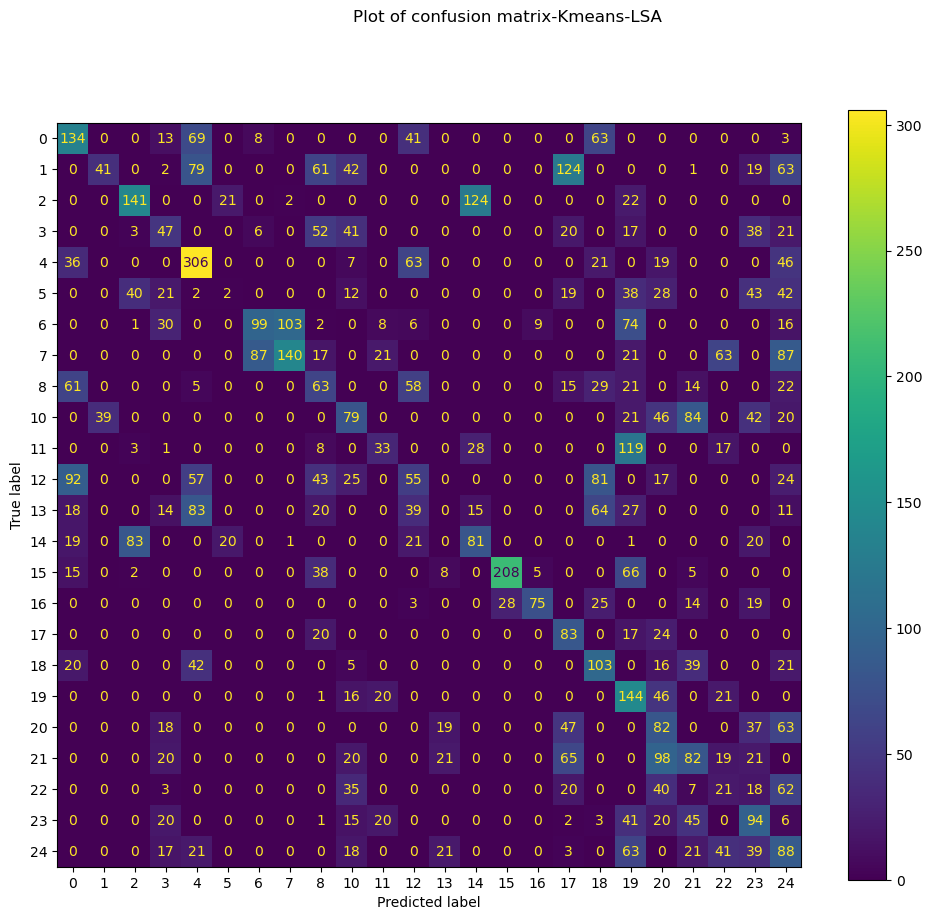

In [18]:
mod_km_lsa_test = mod_km_lsa.predict(X_lsa_test)
cm , acc_km_test, y_pred_lsa = get_labels(y_test, mod_km_lsa_test)
print(acc_km_test)
fig = cm.figure_
fig.set_figwidth(12)
fig.set_figheight(10) 
fig.suptitle('Plot of confusion matrix-Kmeans-LSA')

**4.3**

Kmeans did not get great reults. Kmeans on the PCA dataframe achieved an accuracy of .177.\
Kmeans on the LSA dataframe achieved an accuracy of .253. 

LSA dimensionality reduction seems to work better than PCA for this type of data but the results are still not great. 

# 4. Alternative Models

In [ ]:
# 4.1 Hierarchical based clusters
# Birch
def birch_me(X = X_pca, t = .5 , bf = 50):
    mod_bir = Birch(n_clusters = kn, threshold = t, branching_factor = bf)
    mod_bir_fit = mod_bir.fit(X)
    
    return mod_bir_fit

threshhold = [.25,.5,.75,1]
branch_f = [25,50,75,100]

for t in threshhold:
    for bf in branch_f:
        model = birch_me(t = t , bf = bf)
        cm , acc, y_pred = get_labels(y_train, model.labels_)
        pyplot.close()
        print(acc)
        

pyplot.hist(model.labels_, bins = kn)
cm , acc, y_pred = get_labels(y_train, mod_bir_fit.labels_)

print(acc)

fig = cm.figure_
fig.set_figwidth(12)
fig.set_figheight(10) 
fig.suptitle('Plot of confusion matrix-BIRCH')

0.20382443999271535


Text(0.5, 0.98, 'Plot of confusion matrix-BIRCH')

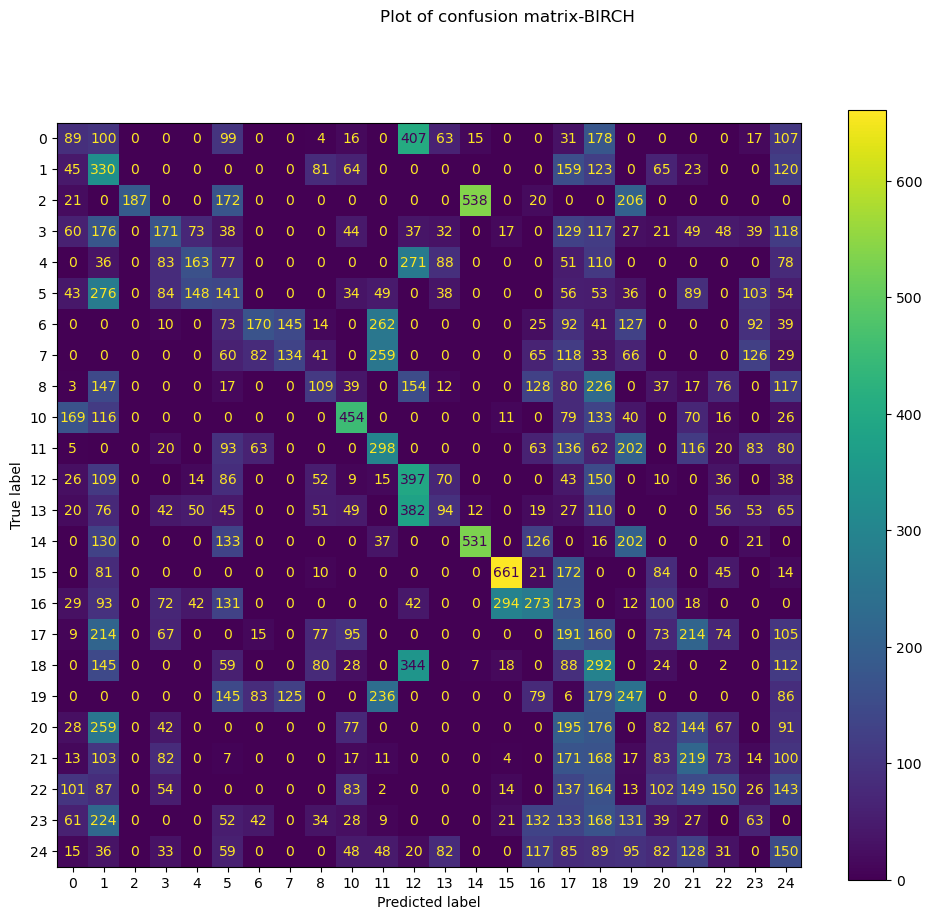

In [20]:
mod_bir = Birch(n_clusters = kn, threshold = .75, branching_factor = 75)
mod_bir_fit = mod_bir.fit(X_pca)

cm , acc, y_pred_bir = get_labels(y_train, mod_bir_fit.labels_)

print(acc)

fig = cm.figure_
fig.set_figwidth(12)
fig.set_figheight(10) 
fig.suptitle('Plot of confusion matrix-BIRCH')

(array([ 737., 2738.,  187.,  760.,  490., 1487.,  455.,  404.,  553.,
           0., 1085., 1226., 2054.,  479., 1103., 1040., 1068., 2352.,
        2748., 1421.,  802., 1263.,  694.,  637., 1672.]),
 array([ 0.  ,  0.96,  1.92,  2.88,  3.84,  4.8 ,  5.76,  6.72,  7.68,
         8.64,  9.6 , 10.56, 11.52, 12.48, 13.44, 14.4 , 15.36, 16.32,
        17.28, 18.24, 19.2 , 20.16, 21.12, 22.08, 23.04, 24.  ]),
 <BarContainer object of 25 artists>)

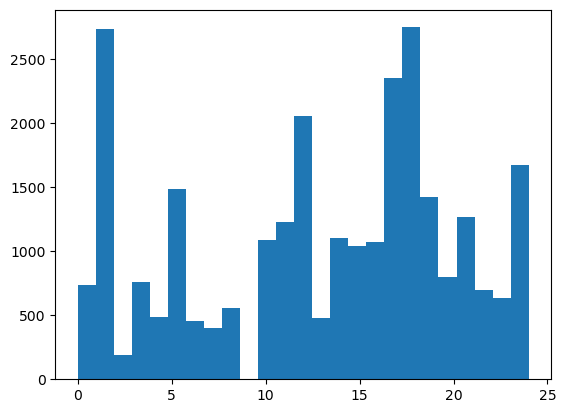

In [21]:
pyplot.hist(y_pred_bir, bins = kn+1)


In [ ]:
# 4.2
# Distribution based clusters
# Gaussian Mixture

def gaus_me(X = X_lsa, cov = 'full', iter_ = 100):
    
    mod_gm = GaussianMixture(n_components = kn, covariance_type = cov, max_iter = iter_)
    mod_gm_fit = mod_gm.fit(X)
    mod_gm_pred = mod_gm_fit.predict(X)
    
    return mod_gm_pred

iter_ = [25,50,100,150]
cov = ['full','tied','diag','spherical']

for i in iter_:
    for c in cov:
        label = gaus_me(cov = c, iter_ = i)
        cm , acc, y_pred = get_labels(y_train, label)
        pyplot.close()
        print(acc)
    
    
    
pyplot.hist(label, bins = kn)
cm , acc, y_pred = get_labels(y_train, label)
print(acc)

fig = cm.figure_
fig.set_figwidth(12)
fig.set_figheight(10) 
fig.suptitle('Plot of confusion matrix-GaussianMixture')

0.252230923329084


Text(0.5, 0.98, 'Plot of confusion matrix-GaussianMixture')

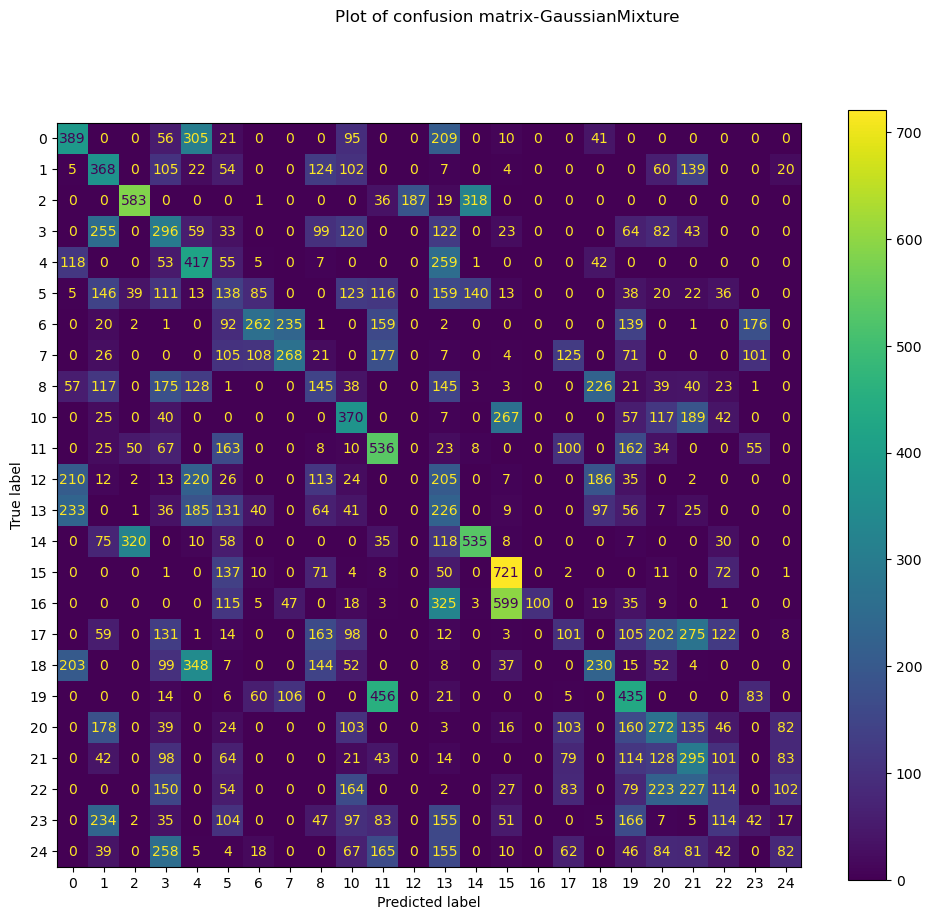

In [22]:
mod_gm = GaussianMixture(n_components = kn, covariance_type = 'spherical', max_iter = 150)
mod_gm_fit = mod_gm.fit(X_lsa)
mod_gm_pred = mod_gm_fit.predict(X_lsa)
mod_gm_test = mod_gm_fit.predict(X_lsa_test)

cm , acc_gm_train, y_pred_gm = get_labels(y_train, mod_gm_pred)
print(acc_gm_train)

fig = cm.figure_
fig.set_figwidth(12)
fig.set_figheight(10) 
fig.suptitle('Plot of confusion matrix-GaussianMixture')

(array([1220., 1621.,  999., 1778., 1713., 1406.,  594.,  656., 1007.,
           0., 1547., 1817.,  187., 2253., 1008., 1812.,  100.,  660.,
         846., 1805., 1347., 1483.,  743.,  458.,  395.]),
 array([ 0.  ,  0.96,  1.92,  2.88,  3.84,  4.8 ,  5.76,  6.72,  7.68,
         8.64,  9.6 , 10.56, 11.52, 12.48, 13.44, 14.4 , 15.36, 16.32,
        17.28, 18.24, 19.2 , 20.16, 21.12, 22.08, 23.04, 24.  ]),
 <BarContainer object of 25 artists>)

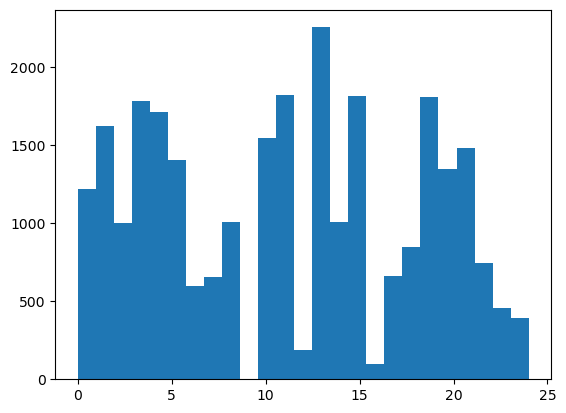

In [23]:
pyplot.hist(y_pred_gm, bins = kn+1)


0.31344116006692696


Text(0.5, 0.98, 'Plot of confusion matrix-GaussianMixture-Test')

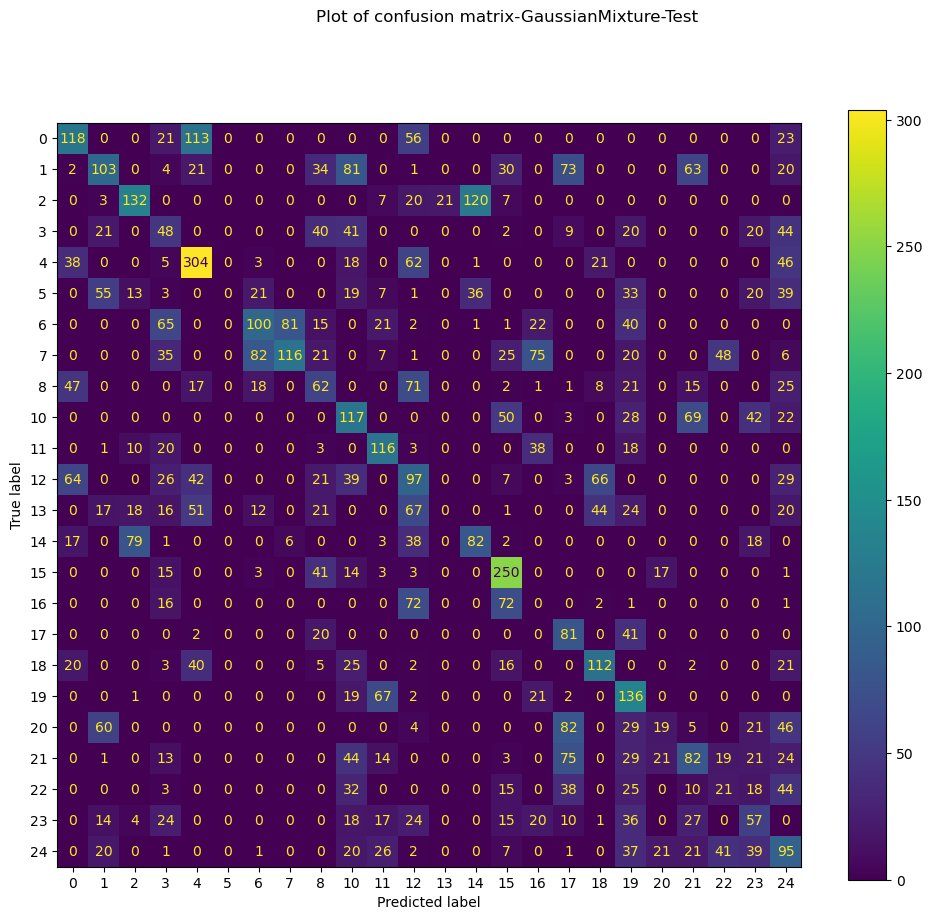

In [24]:
mod_gm_test = mod_gm_fit.predict(X_lsa_test)

cm , acc_gm_test, y_pred_gm = get_labels(y_test, mod_gm_test)
print(acc_gm_test)

fig = cm.figure_
fig.set_figwidth(12)
fig.set_figheight(10) 
fig.suptitle('Plot of confusion matrix-GaussianMixture-Test')

# 5 
# Ensemble Clustering

In [ ]:
# 5.1 Ensemble function
# Ensemble of N minibatch Kmeans models
def cluster_me(k , X , kn = kn):
    # generate cluster forest
    cluster_forest = k * [MiniBatchKMeans(n_clusters = kn, batch_size = 50, n_init = 10, init = 'random')]        
    temp = pd.DataFrame()
    csm_matrix = pd.DataFrame()
    i = 0
    cluster_forest_fit = []
    for mod in cluster_forest:
        fit = mod.fit(X)
        cluster_forest_fit.append(fit)
        label = fit.labels_
        cm , acc, y_pred = get_labels(y_train, fit.labels_)
        pyplot.close()
        #print(acc)
        temp[0] = y_pred
        csm_matrix = pd.concat([csm_matrix,temp], axis = 1)
        i = i+1
            
    y_pred_ensemble = []
        
    csm_matrix[:1]
    ans = csm_matrix.mode(axis=1)
    y_pred_ensemble = ans[0]
    
    acc = accuracy_score(y_train,y_pred_ensemble)
    return y_pred_ensemble



In [ ]:
# 5.2 and 5.3 tune for N and build cluster model
n = [5,10,25,50,100,250,500]
acc_k = []
for k in n:
    y_pred_ensemble = cluster_me(k, X = X_lsa)
    acc = accuracy_score(y_train,y_pred_ensemble)
    print(acc)
    acc_k.append([k,acc])


pyplot.hist(y_pred_ensemble, bins = kn)

cm = confusion_matrix(y_train,y_pred_ensemble)
cmd = ConfusionMatrixDisplay.from_predictions(y_train,y_pred_ensemble)
fig = cmd.figure_
fig.set_figwidth(12)
fig.set_figheight(10) 
fig.suptitle('Plot of confusion matrix-Kmeans-ENSEMBLE')

**5.4**
**Analysis**

I tried to create an ensemble cluster forest but was unsuccesful. I tried several different \
hyperparameters and techniques but ultimately it was very erratic and accuracy numbers on the \
training set was all over the place. There does not appear to be enough variability in the \
minibatchKmeans model with this dataset to create an accurate ensemble model. 

# 6
# Supervised Learning Example

In [25]:
# 6.1 
# initialize K nearest neighbor model

mod_knn = KNeighborsClassifier(n_neighbors=5).fit(X_lsa, y_train)
y_pred = mod_knn.predict(X_lsa)
y_pred_test_knn = mod_knn.predict(X_lsa_test)

1.0


Text(0.5, 0.98, 'Plot of confusion matrix-Knn-Supervised')

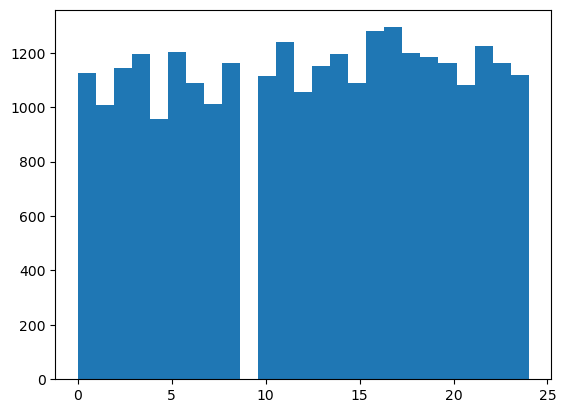

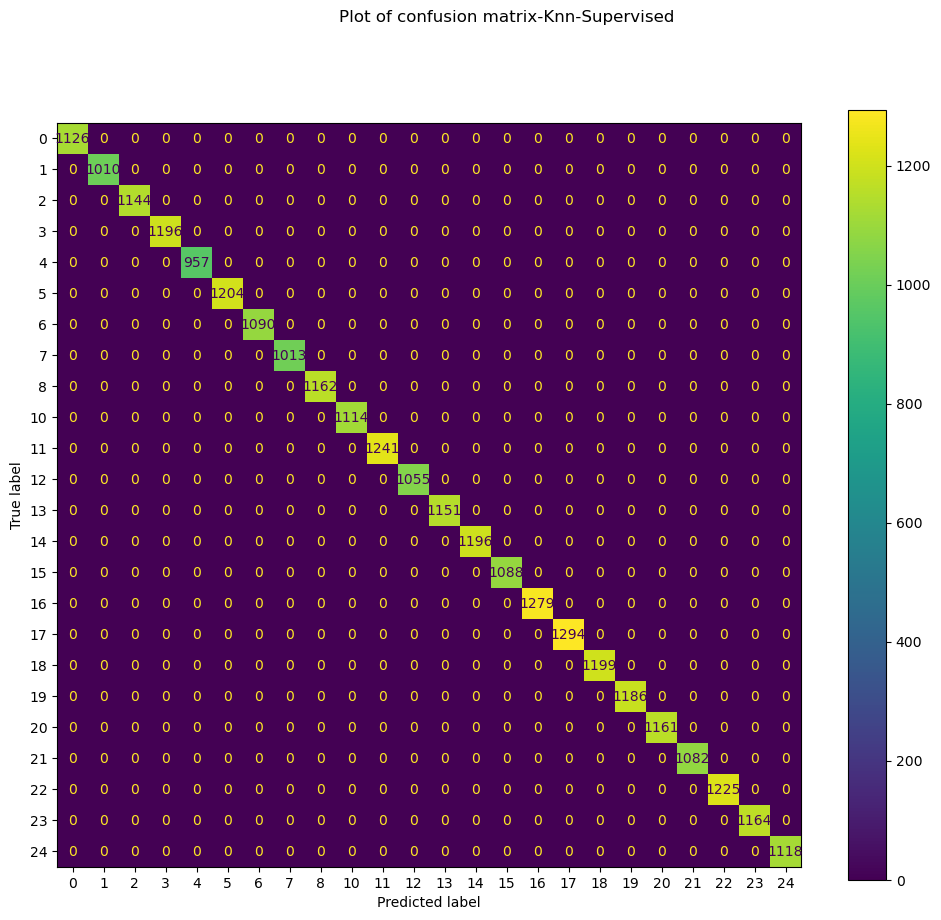

In [26]:

acc_kn_train = accuracy_score(y_train,y_pred)
print(acc_kn_train)
pyplot.hist(y_pred, bins = kn+1)
cmd = ConfusionMatrixDisplay.from_predictions(y_train,y_pred)
fig = cmd.figure_
fig.set_figwidth(12)
fig.set_figheight(10) 
fig.suptitle('Plot of confusion matrix-Knn-Supervised')

0.8244562186279978


Text(0.5, 0.98, 'Plot of confusion matrix-Knn-Supervised')

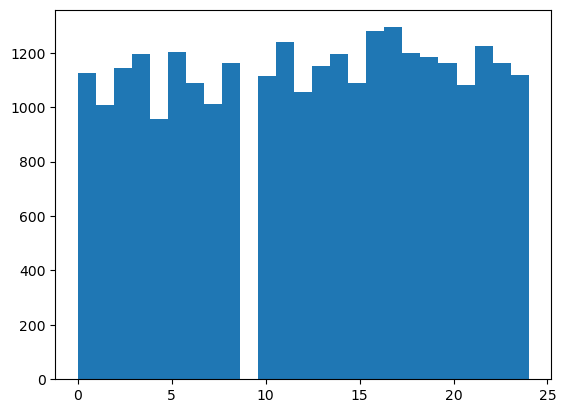

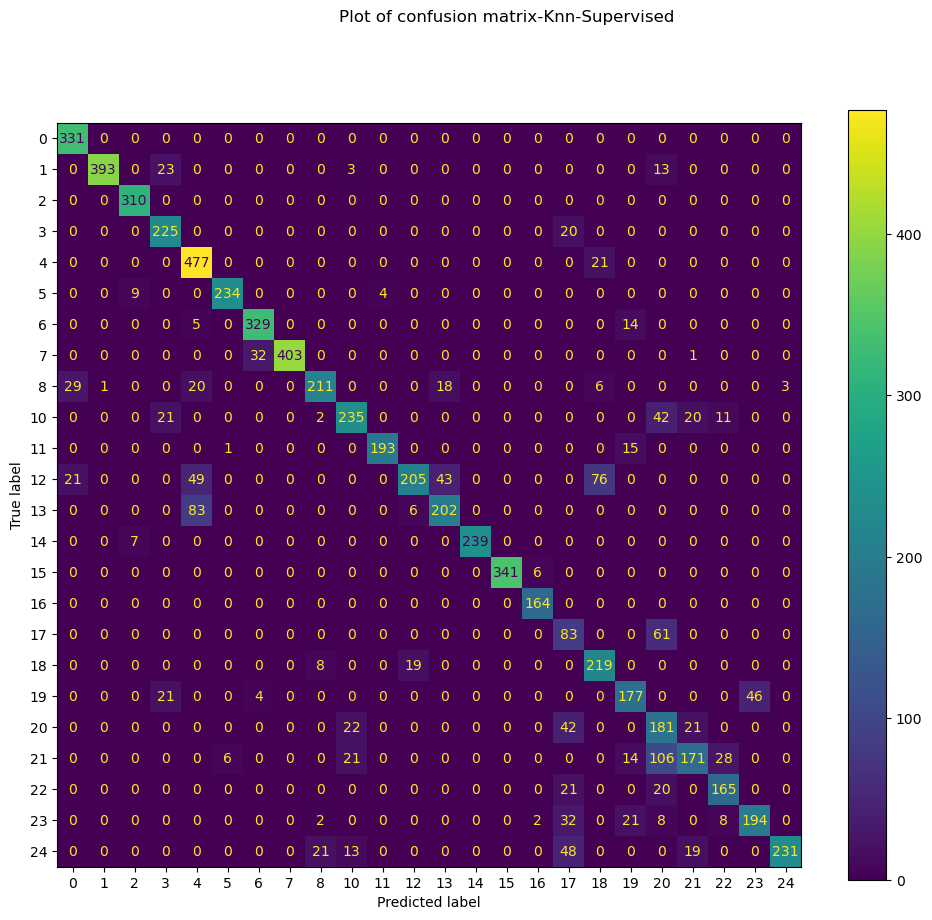

In [27]:
acc_kn_test = accuracy_score(y_test,y_pred_test_knn)
print(acc_kn_test)
pyplot.hist(y_pred, bins = kn+1)
cmd = ConfusionMatrixDisplay.from_predictions(y_test,y_pred_test_knn)
fig = cmd.figure_
fig.set_figwidth(12)
fig.set_figheight(10) 
fig.suptitle('Plot of confusion matrix-Knn-Supervised')

**6.2 Hyperparameter tuning** \
Model accuraccy is already at 1.0 no need for tuning

**6.3 Analysis** \
Supervised model performs great on the training data. \
Not a lot of tuning and model is very easy to implement.

# 7
# Conclusion

In [28]:
print('Best Kmeans model had a train accuracy of ',acc_km_train,'and a test accuracy of',acc_km_test)
print('Best Alternative model (gaussian mix) had a train accuracy of ',acc_gm_train,'and a test accuracy of',acc_gm_test)
print('Supervised Knn model had a train accuracy of ',acc_kn_train,'and a test accuracy of',acc_kn_test)

Best Kmeans model had a train accuracy of  0.2583864505554544 and a test accuracy of 0.30688789737869493
Best Alternative model (gaussian mix) had a train accuracy of  0.252230923329084 and a test accuracy of 0.31344116006692696
Supervised Knn model had a train accuracy of  1.0 and a test accuracy of 0.8244562186279978


For this project my goal was to develop an unsupervised approach to a currently solved data problem. THe dataset used was a mnist sign language dataseet. THe problem has been solved using supervised and deep learning approaches but as of yet has not been succusfully solved using unsupervised clustering. I tried several different dimensionality reduction technique eventually landing on LSA over PCA. I then used first Kmeans clustering and then several alternative clustering models to solve this problem. The best alternative model was gaussian mix clustering which is a distribution based clustering algorithm. I tuned the hyperparameters for each model as best as I could through an itertive process. I also attempted an ensemble clustering algorithm using minibatchKmeans but the results were erratic and not repeatable.  

For the results the Kmeans model achieved a training accuracy of .258 and a test accuracy of .307. The gaussian mix model achieved a training accuracy of .252 and a test accuracy of .313. The base line supervised learning model with no tuning achieved a train accuracy of 1.0 and a test accuracy of .824. 

As you can see the supervised approach far exceded the unsupervised approach with much less effort. What is interesteing is the test accuracy for both unsupervised models was higher than the training accuracy. Future approaches to improve on the unsupervised algorithms might focus on better dimensionality reduction techniques or data preprocessing techniques. THe clusters generated had a lot of point overlaps and did not have clearly defined boundries. 

# references

Stanislas Morbieu - Accuracy: from classification to clustering evaluation - 04 June 2019\
https://smorbieu.gitlab.io/accuracy-from-classification-to-clustering-evaluation/

Ajitesh Kumar - PCA Explained Variance Concepts with Python Example - 14 April 2023\
https://vitalflux.com/pca-explained-variance-concept-python-example/


Joao Pedro - How to ensemble Clustering Algorithms - 19 May 2022\
https://towardsdatascience.com/how-to-ensemble-clustering-algorithms-bf78d7602265

Milecia McGregor - 8 Clustering Algorithms in Machine Learning that All Data Scientists Should Know - 21 September 2020\
https://www.freecodecamp.org/news/8-clustering-algorithms-in-machine-learning-that-all-data-scientists-should-know/